## Import modules

In [1]:
import os
import numpy as np
import math
import statistics
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Load output test probabilitites and true labels for each model

For every model there are 2 files generated in numpy binary format:

  **probabilities.npy** - numpy array of size **TEST POINT CLOUDS CLOUD x CLASSES COUNT x MODELS COUNT** with output classification probability for each of 10 individually trained models

  **true_labels.npy** - numpy array of size **TEST POINT CLOUDS CLOUD** with true labels data

In [22]:
# Base models
BASE_MODELS = ['pointnet', 'pointnet++', 'so-net', 'kcnet', 'deepsets', 'dgcnn', 'pointcnn']
BASE_MODELS_ALIASES = ['PointNet', 'PointNet++', 'SO-Net', 'KCNet', 'DeepSets', 'DGCNN', 'PointCNN']
SONET_BAGGING_MODELS = ['so-net_sz_01', 'so-net_sz_02', 'so-net_sz_03', 'so-net_sz_04', 'so-net_sz_05', 'so-net_sz_06',
                        'so-net_sz_07', 'so-net_sz_08', 'so-net_sz_09', 'so-net_bagging']
SONET_CONST_MODELS = ['so-net_TTT', 'so-net_FFT', 'so-net_FTF', 'so-net_TFF', 'so-net_TTF', 'so-net_TFT', 'so-net_FTT']
SONET_CLASSIFIER_ENSEMBLE = ['so-net_' + str(i) for i in range(1, 11)]
ALL_MODELS = BASE_MODELS + SONET_BAGGING_MODELS + SONET_CONST_MODELS + SONET_CLASSIFIER_ENSEMBLE

CLASS_NAMES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl',
               'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser',
               'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop',
               'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio',
               'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet',
               'tv_stand', 'vase', 'wardrobe', 'xbox']
CLASS_TEST_INSTANCES = [100, 50, 100, 20, 100, 100, 20, 100, 100, 20, 20, 20, 86, 20,
                        86, 20, 100, 100, 20, 20, 20, 100, 100, 86, 20, 100, 100, 20,
                        100, 20, 100, 20, 20, 100, 20, 100, 100, 100, 20, 20]
CLASSES_COUNT = 40
# MODELS_COUNT = 10
# ENSEMBLE_MODELS_NUMBER = 10

probabilities = {}
true_labels = {}
for model in ALL_MODELS:
    for dir_name in ['models_reordered', 'models_raw', 'models_bagging', 'models_const', 'models_classifier_ensemble']:
        if os.path.exists(os.path.join(dir_name, model)):
            break
    prob_filepath = os.path.join(os.path.join(dir_name, model), 'probabilities.npy')
    label_filepath = os.path.join(os.path.join(dir_name, model), 'true_labels.npy')
    probabilities[model] = np.load(prob_filepath)
    if dir_name != 'models_reordered':
        probabilities[model] = np.transpose(probabilities[model], axes=(2, 0, 1))

    # probabilities[model] =  softmax(probabilities[model])
    idx = np.argmax(probabilities[model], axis=-1)
    hardvote = np.squeeze(np.eye(40)[idx.reshape(-1)]).reshape(probabilities[model].shape)
    e_x = np.exp(probabilities[model])
    softvote = e_x /np.expand_dims(np.sum(e_x, axis=-1), axis=-1)
    probabilities[model] = {'activations': probabilities[model]/np.std(probabilities[model]),
                           'hardvote': hardvote, 'softvote': softvote}
    true_labels[model] = np.load(label_filepath)
    
    for class_idx in range(CLASSES_COUNT):
        error_info = ("Test cloud instances for model " + model + " and class "
                      + str(class_idx) + " differs! Should be " + str(CLASS_TEST_INSTANCES[class_idx])
                      + " but got " + str(np.sum(true_labels[model] == class_idx)))
        assert np.sum(true_labels[model] == class_idx) == CLASS_TEST_INSTANCES[class_idx] or \
          (model=='deepsets' and class_idx==12 and np.sum(true_labels[model] == class_idx) == 85) or \
          (model=='deepsets' and class_idx==39 and np.sum(true_labels[model] == class_idx) == 19) or \
          (model=='deepsets_ep100' and class_idx==12 and np.sum(true_labels[model] == class_idx) == 85) or \
          (model=='deepsets_ep100' and class_idx==39 and np.sum(true_labels[model] == class_idx) == 19), \
          error_info
                
#     assert (probabilities[model].shape[0] == ENSEMBLE_MODELS_NUMBER)
    assert (probabilities[model]['activations'].shape[1] == 2468 or \
            (model=='deepsets' and probabilities[model]['activations'].shape[1] == 2466) or \
           (model=='deepsets_ep100' and probabilities[model]['activations'].shape[1] == 2466))
    assert (probabilities[model]['activations'].shape[2] == CLASSES_COUNT)

## Caclulate statistics

In [3]:
####################################################################################
# Get random subsets
####################################################################################

def get_k_combinations_of_n_elems(n, k, rep):
    """
    Get rep different k-combinations of set of n numbers. If requested reps is greater
    than possible combinations number just return all possible combinations. In our case:
    n - maximum number of ensembled models
    k - actual number of ensembled models
    rep - how many different k subsets of n we want to generate.    
    """
    c_n_k = math.factorial(n) / math.factorial(k) / math.factorial(n-k)
    combinations_number = min(c_n_k, rep)
    
    subsets = []   
    while len(subsets) != combinations_number:
        candidate = np.sort(np.random.choice(n, k, replace=False))
        if not np.array([(el == candidate).all() for el in subsets]).any():
            subsets.append(candidate)
    return np.array(subsets)
        
####################################################################################
# Calc accuracy statistics
####################################################################################

def get_stats_for_num_ens_param(params_list):
    stats = {}
    stats['mean'] = statistics.mean(params_list)
    stats['stddev'] = statistics.stdev(params_list) if len(params_list) > 1 else 0.0
    stats['median'] = statistics.median(params_list)
    stats['min'] = min(params_list)
    stats['max'] = max(params_list)
    return stats

def get_accuracy_stats(models_list, voting_method='activations'):
    accuracy_stats = {}
    for model in models_list:
        subsets = {}
        
        num_ensemble_models = probabilities[model][voting_method].shape[0]
        for num_ens in range(1, num_ensemble_models+1):
            subset = get_k_combinations_of_n_elems(len(probabilities[model][voting_method]),
                                                   num_ens, 100)
            subsets[num_ens] = subset
            
        accuracy_stats[model] = {}

        for num_ens in subsets:
            num_ens_accs = []
            for subset in subsets[num_ens]:
                preds = np.argmax(np.mean(probabilities[model][voting_method][subset], axis=0), axis=-1)
                true = true_labels[model]

                acc = float(np.sum(preds == true))/len(true)
                class_accs = []
                for class_idx in range(CLASSES_COUNT):
                    class_acc = float(np.sum((preds == true) * (true == class_idx)))/float(np.sum(true == class_idx))
                    class_accs.append(class_acc)
                mean_class_acc = statistics.mean(class_accs)
                num_ens_accs.append({'acc': acc, 'mean_class_acc': mean_class_acc, 'class_accs': class_accs})

            num_ens_summary = {}
            num_ens_summary['acc'] = get_stats_for_num_ens_param([x['acc'] for x in num_ens_accs])
            num_ens_summary['mean_class_acc'] = get_stats_for_num_ens_param([x['mean_class_acc'] for x in num_ens_accs])
            num_ens_summary['class_accs'] = []
            for class_idx in range(CLASSES_COUNT):
                num_ens_summary['class_accs'].append(get_stats_for_num_ens_param([x['class_accs'][class_idx] 
                                                                                  for x in num_ens_accs]))
            accuracy_stats[model][num_ens] = num_ens_summary
    return accuracy_stats

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

def plot_acc_in_num_models(ax, acc_stats, acc_type='acc', styles={}, h_factor=0.1, times=None, without_errorbar=False):
    for model in acc_stats:
        x = acc_stats[model].keys()
        y = [acc_stats[model][i][acc_type]['mean'] for i in x]
        if 'stddev' in acc_stats[model][1][acc_type] and not without_errorbar:
            e = [acc_stats[model][i][acc_type]['stddev'] for i in x]
        if times is not None:
            x = [v * times[model] for v in x]
        if 'stddev' in acc_stats[model][1][acc_type] and not without_errorbar:
            ax.errorbar(x, y, e, label=styles[model]['label'], capsize=6, 
                               color=styles[model]['color'],
                              linestyle=styles[model]['linestyle'])
        else:
            ax.plot(x, y, label=styles[model]['label'], 
                               color=styles[model]['color'],
                              linestyle=styles[model]['linestyle'])
       
    if times is None:
        ax.set_xlabel('Number of ensembled models')
    else:
        ax.set_xlabel('Inference time for batch of 4 point clouds [ms]')
        
    if acc_type == 'acc':
        ax.set_ylabel('Instance classification accuracy')
    elif acc_type == 'mean_class_acc':
        ax.set_ylabel('Mean class accuracy')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * h_factor,
                     box.width, box.height * (1.0 - h_factor)])

    #     if plot_legend:
#     # Set legend outside the plot
#         

#         # Put a legend below current axis
#         ax.legend(loc='upper center',
#                   bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=6)
    
    # Show tick labels
    for tk in ax.get_yticklabels():
        tk.set_visible(True)
        
    return ax.get_legend_handles_labels()

## Plot accuracies in function of ensembled models

In [5]:
acc_stats_base_models_voting = {method: get_accuracy_stats(BASE_MODELS, method) for method in 
                                ['activations', 'hardvote', 'softvote']}

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


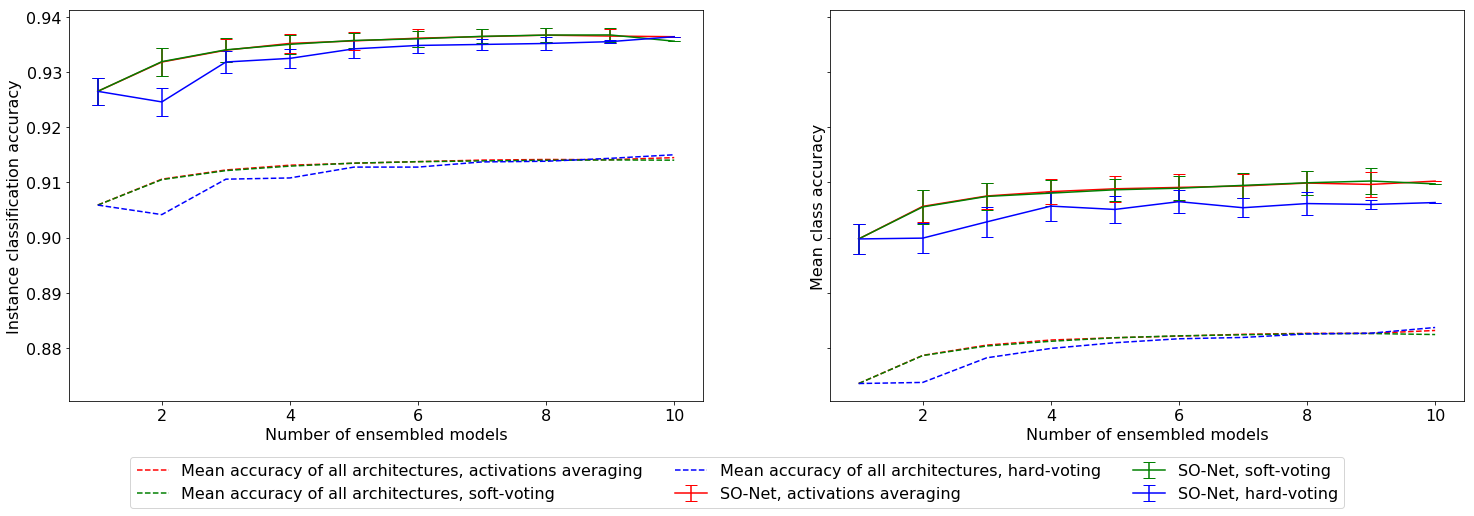

In [6]:
compare_sonet = {method: acc_stats_base_models_voting[method]['so-net'] for method in acc_stats_base_models_voting}
compare_mean_arch = {}
for method in acc_stats_base_models_voting:
    mean_arch_acc = {}
    mean_arch_mca = {}
    for arch in acc_stats_base_models_voting[method]:
        arch_voting = acc_stats_base_models_voting[method][arch]
        for num_models in arch_voting:
            arch_num = arch_voting[num_models]
            arch_num_acc = arch_num['acc']
            arch_num_mca = arch_num['mean_class_acc']
            if num_models not in mean_arch_acc:
                mean_arch_acc[num_models] = []
            if num_models not in mean_arch_mca:
                mean_arch_mca[num_models] = []
            mean_arch_acc[num_models].append(arch_num_acc['mean'])
            mean_arch_mca[num_models].append(arch_num_mca['mean'])
    mean_arch_acc = {x: np.mean(mean_arch_acc[x]) for x in mean_arch_acc}
    mean_arch_mca = {x: np.mean(mean_arch_mca[x]) for x in mean_arch_mca}
    compare_mean_arch[method] = {x: {'acc': {'mean': mean_arch_acc[x]}, 
                                     'mean_class_acc': {'mean': mean_arch_mca[x]}} 
                                 for x in mean_arch_acc}
compare_voting = {}
for item in compare_sonet:
    compare_voting['so-net ' + item] = compare_sonet[item]
for item in compare_mean_arch:
    compare_voting['mean arch ' + item] = compare_mean_arch[item]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 8))
styles = {'so-net activations': {'color': 'r', 'linestyle': '-', 'label': 'SO-Net, activations averaging'},
         'so-net softvote': {'color': 'g', 'linestyle': '-', 'label': 'SO-Net, soft-voting'},
         'so-net hardvote': {'color': 'b', 'linestyle': '-', 'label': 'SO-Net, hard-voting'},
         'mean arch activations': {'color': 'r', 'linestyle': '--',
                                   'label': 'Mean accuracy of all architectures, activations averaging'},
         'mean arch softvote': {'color': 'g', 'linestyle': '--',
                                'label': 'Mean accuracy of all architectures, soft-voting'},
         'mean arch hardvote': {'color': 'b', 'linestyle': '--',
                               'label': 'Mean accuracy of all architectures, hard-voting'}}
handles, labels = plot_acc_in_num_models(ax1, compare_voting, 'acc', styles)
plot_acc_in_num_models(ax2, compare_voting, 'mean_class_acc', styles)
f.legend(handles=handles, loc='lower center', ncol=3)
f.savefig('voting_methods.png', bbox_inches='tight')

In [7]:
acc_stats_base_models = get_accuracy_stats(BASE_MODELS, 'activations')

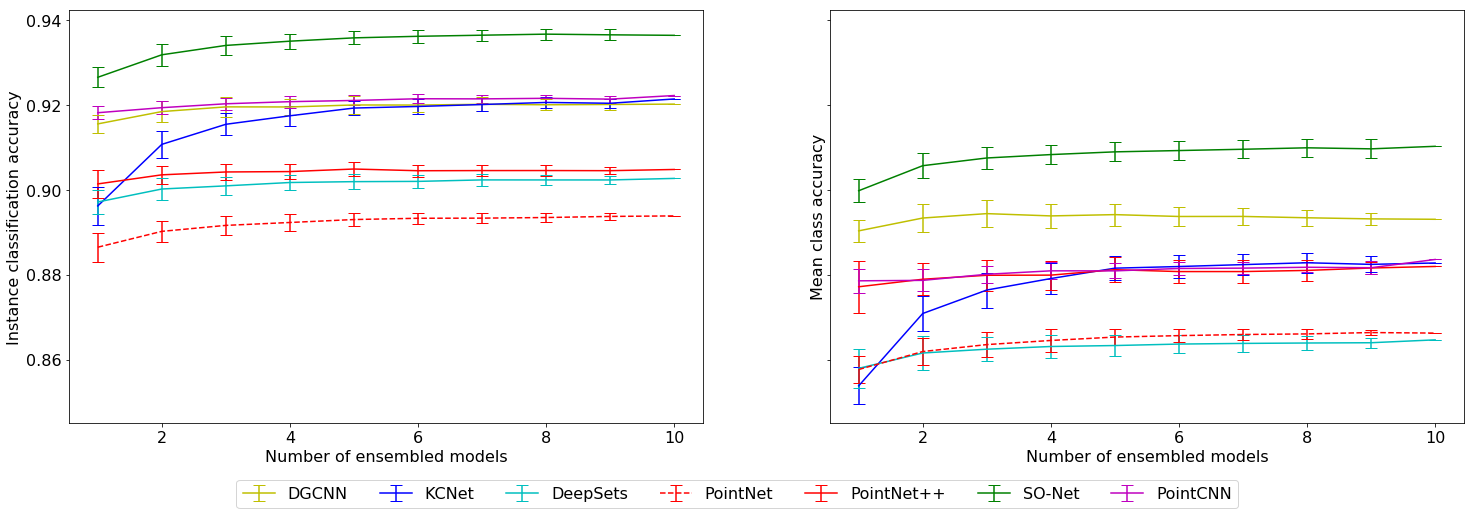

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 8))
#'pointnet', 'pointnet++', 'so-net', 'kcnet', 'deepsets', 'dgcnn', 'pointcnn'
styles = {'pointnet': {'color': 'r', 'linestyle': '--', 'label': 'PointNet'},
         'pointnet++': {'color': 'r', 'linestyle': '-', 'label': 'PointNet++'},
         'so-net': {'color': 'g', 'linestyle': '-', 'label': 'SO-Net'},
         'kcnet': {'color': 'b', 'linestyle': '-', 'label': 'KCNet'},
         'deepsets': {'color': 'c', 'linestyle': '-', 'label': 'DeepSets'},
         'dgcnn': {'color': 'y', 'linestyle': '-', 'label': 'DGCNN'},
         'pointcnn': {'color': 'm', 'linestyle': '-', 'label': 'PointCNN'},}
h = 0.05
handles, labels = plot_acc_in_num_models(ax1, acc_stats_base_models, 'acc', styles, h)
plot_acc_in_num_models(ax2, acc_stats_base_models, 'mean_class_acc', styles, h)
f.legend(handles=handles, loc='lower center', ncol=7)
f.savefig('models_accuracy.png', bbox_inches='tight')

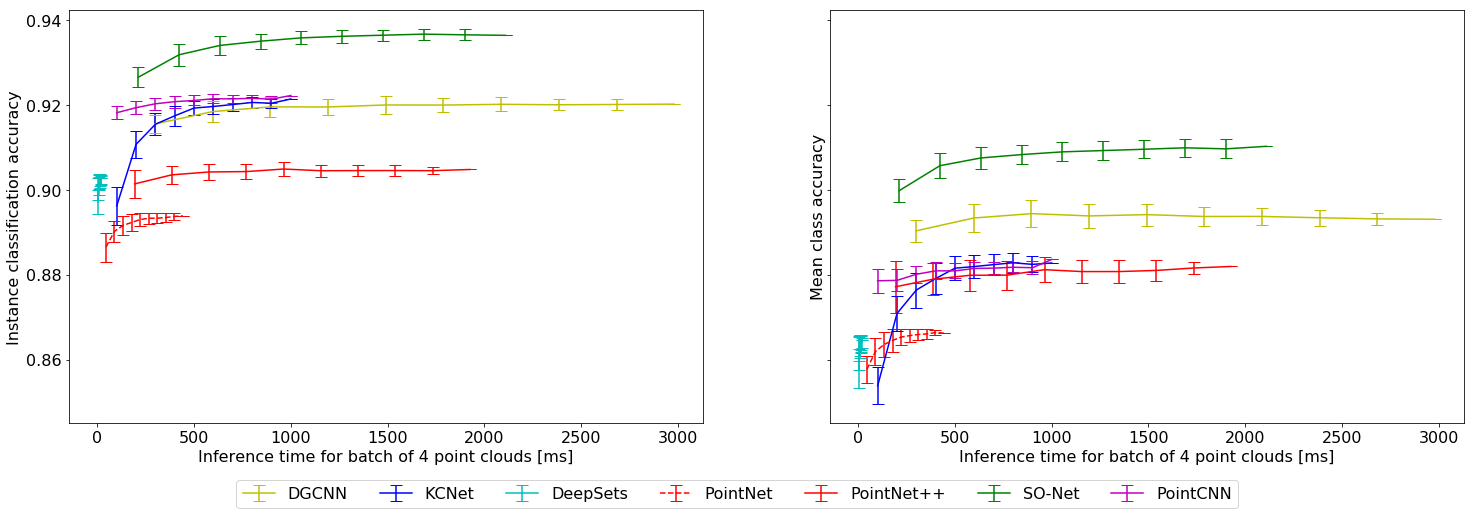

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 8))
#'pointnet', 'pointnet++', 'so-net', 'kcnet', 'deepsets', 'dgcnn', 'pointcnn'
styles = {'pointnet': {'color': 'r', 'linestyle': '--', 'label': 'PointNet'},
         'pointnet++': {'color': 'r', 'linestyle': '-', 'label': 'PointNet++'},
         'so-net': {'color': 'g', 'linestyle': '-', 'label': 'SO-Net'},
         'kcnet': {'color': 'b', 'linestyle': '-', 'label': 'KCNet'},
         'deepsets': {'color': 'c', 'linestyle': '-', 'label': 'DeepSets'},
         'dgcnn': {'color': 'y', 'linestyle': '-', 'label': 'DGCNN'},
         'pointcnn': {'color': 'm', 'linestyle': '-', 'label': 'PointCNN'},}
times = {'deepsets': 2.068129,
         'pointnet': 44.246,
         'pointnet++': 192.551,
         'so-net': 210.979525129858,
         'kcnet': 100, 
         'dgcnn': 298.153,
         'pointcnn': 100}
h = 0.05
handles, labels = plot_acc_in_num_models(ax1, acc_stats_base_models, 'acc', styles, h, times)
plot_acc_in_num_models(ax2, acc_stats_base_models, 'mean_class_acc', styles, h, times)
f.legend(handles=handles, loc='lower center', ncol=7)
f.savefig('models_accuracy.png', bbox_inches='tight')

## Accuracies in function of ensemled models for SO-Net bagging

In [10]:
acc_stats_sonet_bagging = get_accuracy_stats(SONET_BAGGING_MODELS + ['so-net'])

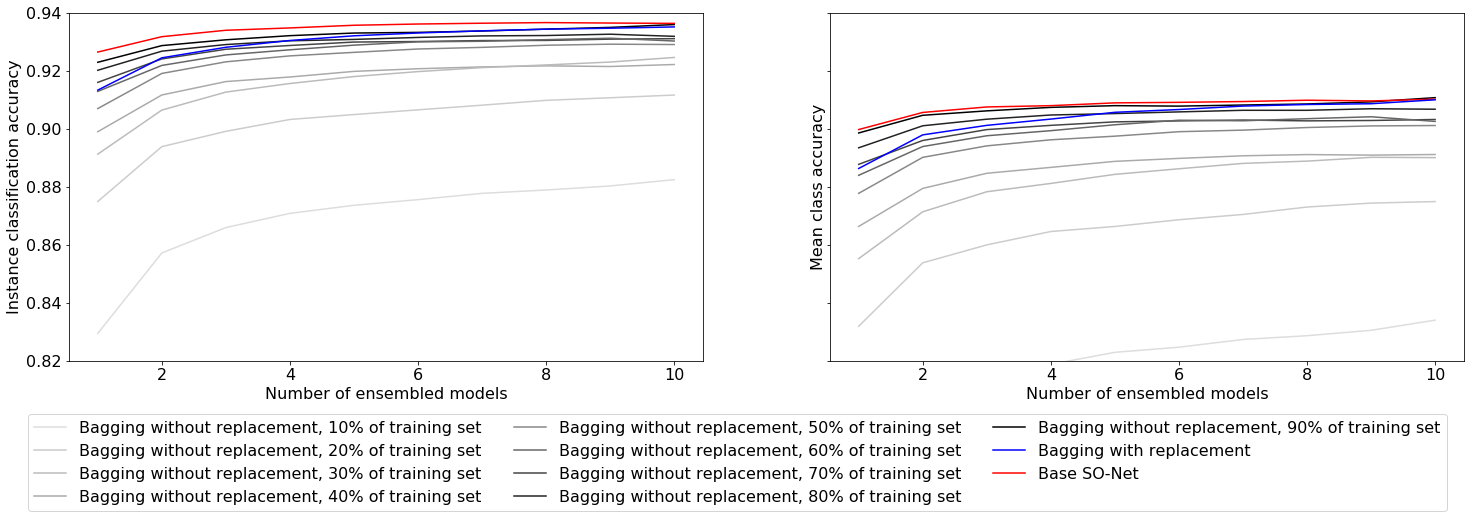

In [74]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 8))
styles = {'so-net': {'color': 'r', 'linestyle': '-', 'label': 'Base SO-Net'},
          'so-net_sz_01': {'color': '#dddddd', 'linestyle': '-', 'label': 'Bagging without replacement, 10% of training set'},
          'so-net_sz_02': {'color': '#cccccc', 'linestyle': '-', 'label': 'Bagging without replacement, 20% of training set'},
          'so-net_sz_03': {'color': '#bbbbbb', 'linestyle': '-', 'label': 'Bagging without replacement, 30% of training set'},
          'so-net_sz_04': {'color': '#aaaaaa', 'linestyle': '-', 'label': 'Bagging without replacement, 40% of training set'},
          'so-net_sz_05': {'color': '#888888', 'linestyle': '-', 'label': 'Bagging without replacement, 50% of training set'},
          'so-net_sz_06': {'color': '#666666', 'linestyle': '-', 'label': 'Bagging without replacement, 60% of training set'},
          'so-net_sz_07': {'color': '#444444', 'linestyle': '-', 'label': 'Bagging without replacement, 70% of training set'},
          'so-net_sz_08': {'color': '#222222', 'linestyle': '-', 'label': 'Bagging without replacement, 80% of training set'},
          'so-net_sz_09': {'color': '#000000', 'linestyle': '-', 'label': 'Bagging without replacement, 90% of training set'},
          'so-net_bagging': {'color': 'b', 'linestyle': '-', 'label': 'Bagging with replacement'}
         }
h = 0.2
handles, labels = plot_acc_in_num_models(ax1, acc_stats_sonet_bagging, 'acc', styles, h, without_errorbar=True)
plot_acc_in_num_models(ax2, acc_stats_sonet_bagging, 'mean_class_acc', styles, h, without_errorbar=True)

# Order handles and labels
order = []
for percent in np.array(np.linspace(10, 90, 9)).astype(int):
    order.append([idx for idx, label in enumerate(labels) if str(percent) in label][0])
order.append([idx for idx, label in enumerate(labels) if 'Bagging with replacement' == label][0])
order.append([idx for idx, label in enumerate(labels) if 'Base SO-Net' == label][0])
labels = np.array(labels)[order].tolist()
handles = np.array(handles)[order].tolist()

f.legend(handles=handles, loc='lower center', ncol=3)
ax1.set_ylim((0.82, 0.94))
f.savefig('images/sonet_bagging.png', bbox_inches='tight')

## Compare results with and without ensemble

In [12]:
data = []
TOTAL_NUM_MODELS = 10
for model in BASE_MODELS:
    data.append([100 * acc_stats_base_models[model][1]['acc']['mean'],
                 100 * acc_stats_base_models[model][TOTAL_NUM_MODELS]['acc']['mean'],
                 100 * acc_stats_base_models[model][1]['mean_class_acc']['mean'],
                 100 * acc_stats_base_models[model][TOTAL_NUM_MODELS]['mean_class_acc']['mean']])
pd.options.display.float_format = '{:,.2f}%'.format
df = pd.DataFrame(data, columns=['Plain acc mean', 'Ensemble acc mean', 
                                 'Plain class acc mean', 'Ensemble class acc mean'], index=BASE_MODELS)
df['Increase acc'] = df['Ensemble acc mean'] - df['Plain acc mean']
df['Increase class acc'] = df['Ensemble class acc mean'] - df['Plain class acc mean']
df

,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
pointnet,88.65%,89.38%,85.77%,86.62%,0.74%,0.86%
pointnet++,90.14%,90.48%,87.71%,88.19%,0.34%,0.48%
so-net,92.65%,93.64%,89.98%,91.02%,0.99%,1.05%
kcnet,89.62%,92.14%,85.38%,88.28%,2.52%,2.89%
deepsets,89.71%,90.27%,85.79%,86.46%,0.56%,0.67%
dgcnn,91.55%,92.02%,89.03%,89.30%,0.47%,0.27%
pointcnn,91.82%,92.22%,87.85%,88.36%,0.41%,0.50%


In [13]:
data = []
TOTAL_NUM_MODELS = 10
for model in SONET_BAGGING_MODELS:
    data.append([100 * acc_stats_sonet_bagging[model][1]['acc']['mean'],
                 100 * acc_stats_sonet_bagging[model][TOTAL_NUM_MODELS]['acc']['mean'],
                 100 * acc_stats_sonet_bagging[model][1]['mean_class_acc']['mean'],
                 100 * acc_stats_sonet_bagging[model][TOTAL_NUM_MODELS]['mean_class_acc']['mean']])
pd.options.display.float_format = '{:,.2f}%'.format
df = pd.DataFrame(data, columns=['Plain acc mean', 'Ensemble acc mean', 
                                 'Plain class acc mean', 'Ensemble class acc mean'], index=SONET_BAGGING_MODELS)
df['Increase acc'] = df['Ensemble acc mean'] - df['Plain acc mean']
df['Increase class acc'] = df['Ensemble class acc mean'] - df['Plain class acc mean']
df

,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
so-net_sz_01,82.95%,88.25%,76.88%,83.40%,5.30%,6.53%
so-net_sz_02,87.50%,91.17%,83.19%,87.49%,3.67%,4.30%
so-net_sz_03,89.13%,92.46%,85.53%,89.01%,3.33%,3.48%
so-net_sz_04,89.90%,92.22%,86.64%,89.12%,2.32%,2.48%
so-net_sz_05,90.70%,92.91%,87.78%,90.12%,2.21%,2.34%
so-net_sz_06,91.29%,93.03%,88.40%,90.26%,1.74%,1.86%
so-net_sz_07,91.60%,93.11%,88.78%,90.32%,1.51%,1.55%
so-net_sz_08,92.02%,93.19%,89.35%,90.68%,1.17%,1.33%
so-net_sz_09,92.30%,93.60%,89.86%,91.08%,1.30%,1.22%
so-net_bagging,91.34%,93.52%,88.63%,91.00%,2.18%,2.37%


In [14]:
acc_stats_classifier_ensemble = get_accuracy_stats(SONET_CLASSIFIER_ENSEMBLE, 'activations')

In [15]:
data = []
TOTAL_NUM_MODELS = 5
for model in SONET_CLASSIFIER_ENSEMBLE:
    data.append([100 * acc_stats_classifier_ensemble[model][1]['acc']['mean'],
                 100 * acc_stats_classifier_ensemble[model][TOTAL_NUM_MODELS]['acc']['mean'],
                 100 * acc_stats_classifier_ensemble[model][1]['mean_class_acc']['mean'],
                 100 * acc_stats_classifier_ensemble[model][TOTAL_NUM_MODELS]['mean_class_acc']['mean']])
pd.options.display.float_format = '{:,.2f}%'.format
df = pd.DataFrame(data, columns=['Plain acc mean', 'Ensemble acc mean', 
                                 'Plain class acc mean', 'Ensemble class acc mean'], index=SONET_CLASSIFIER_ENSEMBLE)
df['Increase acc'] = df['Ensemble acc mean'] - df['Plain acc mean']
df['Increase class acc'] = df['Ensemble class acc mean'] - df['Plain class acc mean']
df.describe()

,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
count,10.00%,10.00%,10.00%,10.00%,10.00%,10.00%
mean,92.43%,92.69%,89.80%,89.98%,0.25%,0.18%
std,0.19%,0.28%,0.21%,0.28%,0.12%,0.12%
min,92.18%,92.22%,89.58%,89.60%,0.04%,0.01%
25%,92.30%,92.55%,89.61%,89.85%,0.17%,0.07%
50%,92.41%,92.61%,89.77%,89.89%,0.26%,0.20%
75%,92.48%,92.82%,89.97%,90.28%,0.36%,0.27%
max,92.80%,93.19%,90.13%,90.33%,0.40%,0.36%


## Test for best model selection

In [16]:
def test_result_for_validation_max(model_name):
    print('Caclutaing', model_name)
    mean_acc = 100 * acc_stats_base_models[model_name][1]['acc']['mean']
    max_acc = 100 * acc_stats_base_models[model_name][1]['acc']['max']
    
    indices = {}
    for k in range(40):
        indices[k] = [i for i, x in enumerate(true_labels[model_name]) if x == k]
    validation_max_res = []
    test_res_at_validation_max = []

    for _ in range(1000):
        validation_indices = []
        test_indices = []
        for k in indices:
            random.shuffle(indices[k])
            split_idx = int(len(indices[k])/2)
            validation_indices += indices[k][:split_idx]
            test_indices += indices[k][split_idx:]
        validation_indices = sorted(validation_indices)
        test_indices = sorted(test_indices)

        validation_true_labels = true_labels[model_name][validation_indices]
        validation_probabilities = probabilities[model_name][:, validation_indices]
        test_true_labels = true_labels[model_name][test_indices]
        test_probabilities = probabilities[model_name][:, test_indices]

        validation_predictions = np.argmax(validation_probabilities, axis=2)
        validation_compare = np.equal(validation_predictions, np.expand_dims(validation_true_labels, 0))
        validation_accuracies = np.mean(validation_compare, axis=1)

        test_predictions = np.argmax(test_probabilities, axis=2)
        test_compare = np.equal(test_predictions, np.expand_dims(test_true_labels, 0))
        test_accuracies = np.mean(test_compare, axis=1)

        validation_max_res.append(np.max(validation_accuracies))
        test_res_at_validation_max.append(test_accuracies[np.argmax(validation_accuracies)])

    mean_valid_max = 100 * statistics.mean(validation_max_res)
    mean_test_at_valid_max = 100 * statistics.mean(test_res_at_validation_max)

    return [mean_acc, max_acc, mean_valid_max, mean_test_at_valid_max]
    
data = []
for model in BASE_MODELS:
    data.append(test_result_for_validation_max(model))
pd.DataFrame(data, 
             columns=['Mean acc', 'Max acc', 'Mean of max valid acc', 'Mean of test acc at valid max'],
             index=BASE_MODELS)

Caclutaing pointnet


TypeError: unhashable type: 'slice'

In [17]:
min_values = []
for idx in range(CLASSES_COUNT):
    class_plain_mean = [100 * acc_stats_base_models[x][1]['class_accs'][idx]['mean'] for x in BASE_MODELS]
    class_ensemble_mean = [100 * acc_stats_base_models[x][10]['class_accs'][idx]['mean'] for x in BASE_MODELS]
    min_values.append((CLASS_NAMES[idx], idx, min(class_ensemble_mean + class_plain_mean)))
min_values = sorted(min_values, key=lambda x: x[-1])
low_acc_classes = sorted(min_values[:15], key=lambda x: x[1])
high_acc_classes = sorted(min_values[15:], key=lambda x: x[1])

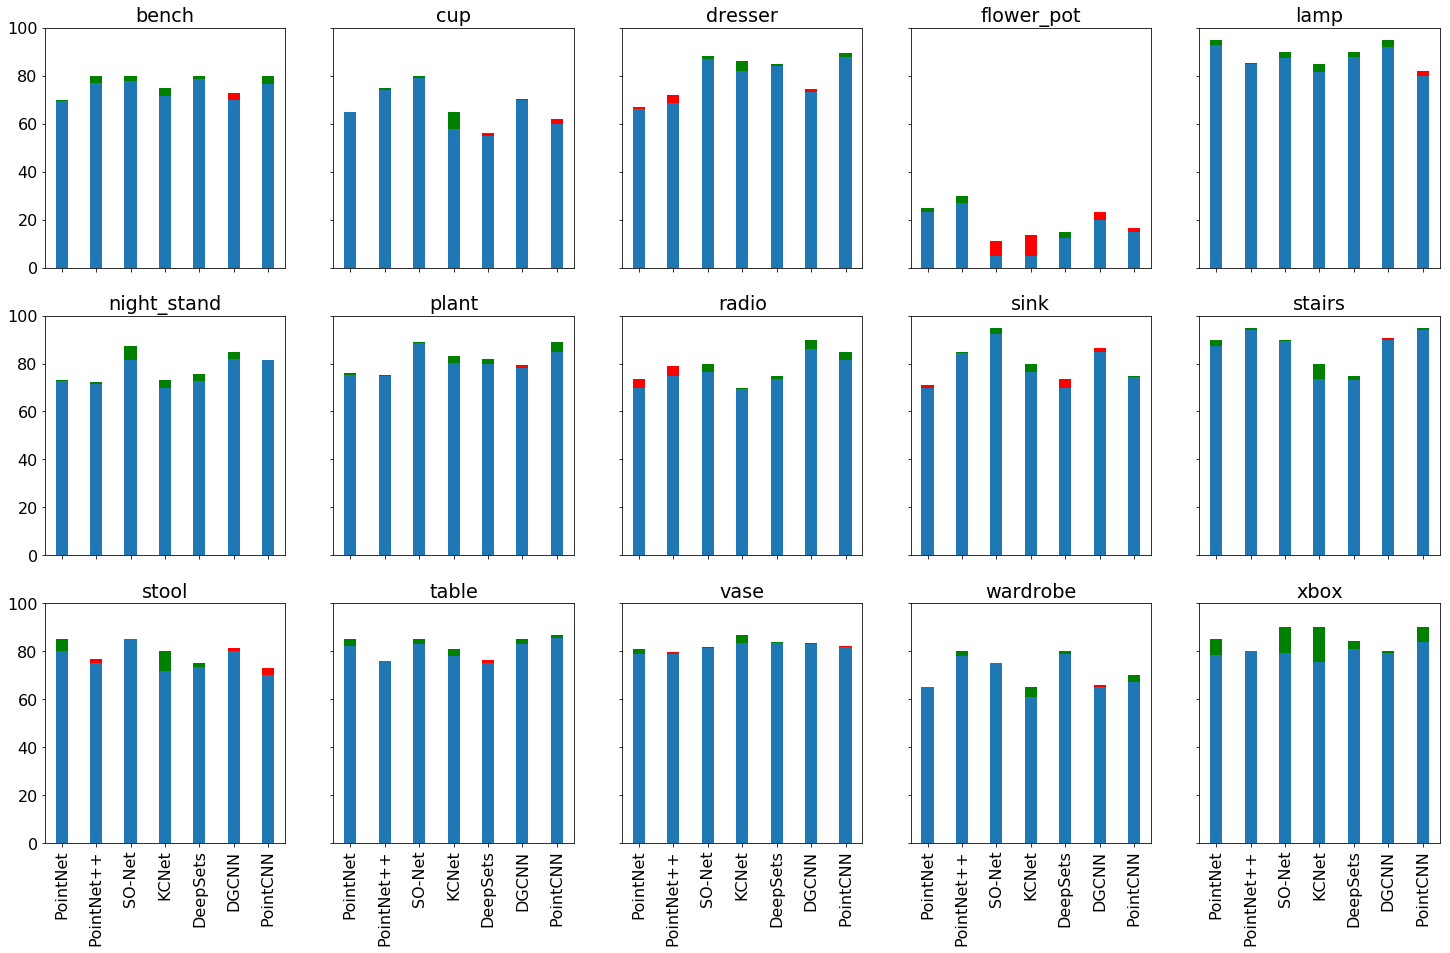

In [25]:
def draw_class_accs(acc_classes_list, y_lim):
    ind = np.arange(len(BASE_MODELS))    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    num_cols = 5
    num_rows = int(len(acc_classes_list) / num_cols)
    f, axes = plt.subplots(num_rows, num_cols, sharey=True, sharex=True, figsize=(25, 5 * num_rows))
    plt.setp(axes, xticks=ind, xticklabels=BASE_MODELS_ALIASES, yticks=range(y_lim[0],y_lim[1] + 1, int((y_lim[1]-y_lim[0])/5)))

    for c in range(num_cols):
        for r in range(num_rows):
            tmp_idx = c + num_cols * r
            idx = acc_classes_list[tmp_idx][1]
            class_plain_mean = [100 * acc_stats_base_models[x][1]['class_accs'][idx]['mean'] for x in BASE_MODELS]
            # class_plain_stddev = [acc_stats_base_models[x][1]['class_accs'][idx]['stddev'] for x in BASE_MODELS]
            class_ensemble_mean = [100 * acc_stats_base_models[x][10]['class_accs'][idx]['mean'] for x in BASE_MODELS]
            diff = [class_ensemble_mean[x] - class_plain_mean[x] for x in range(len(class_plain_mean))]
            diff_up = [x if x > 0 else 0 for x in diff]
            diff_down = [x if x < 0 else 0 for x in diff]
            axes[r][c].bar(ind, class_plain_mean, width, label='Plain')
            axes[r][c].bar(ind, diff_up, width,
                         bottom=class_plain_mean, label='Diff', color='g')
            axes[r][c].bar(ind, diff_down, width,
                         bottom=class_plain_mean, label='Diff', color='r')
            axes[r][c].set_title(CLASS_NAMES[idx])
            axes[r][c].set_ylim(y_lim)
            for tick in axes[r][c].get_xticklabels():
                tick.set_rotation(90)
    return f

f = draw_class_accs(low_acc_classes, [0, 100])
f.savefig('class_accuracy_1.png', bbox_inches='tight')

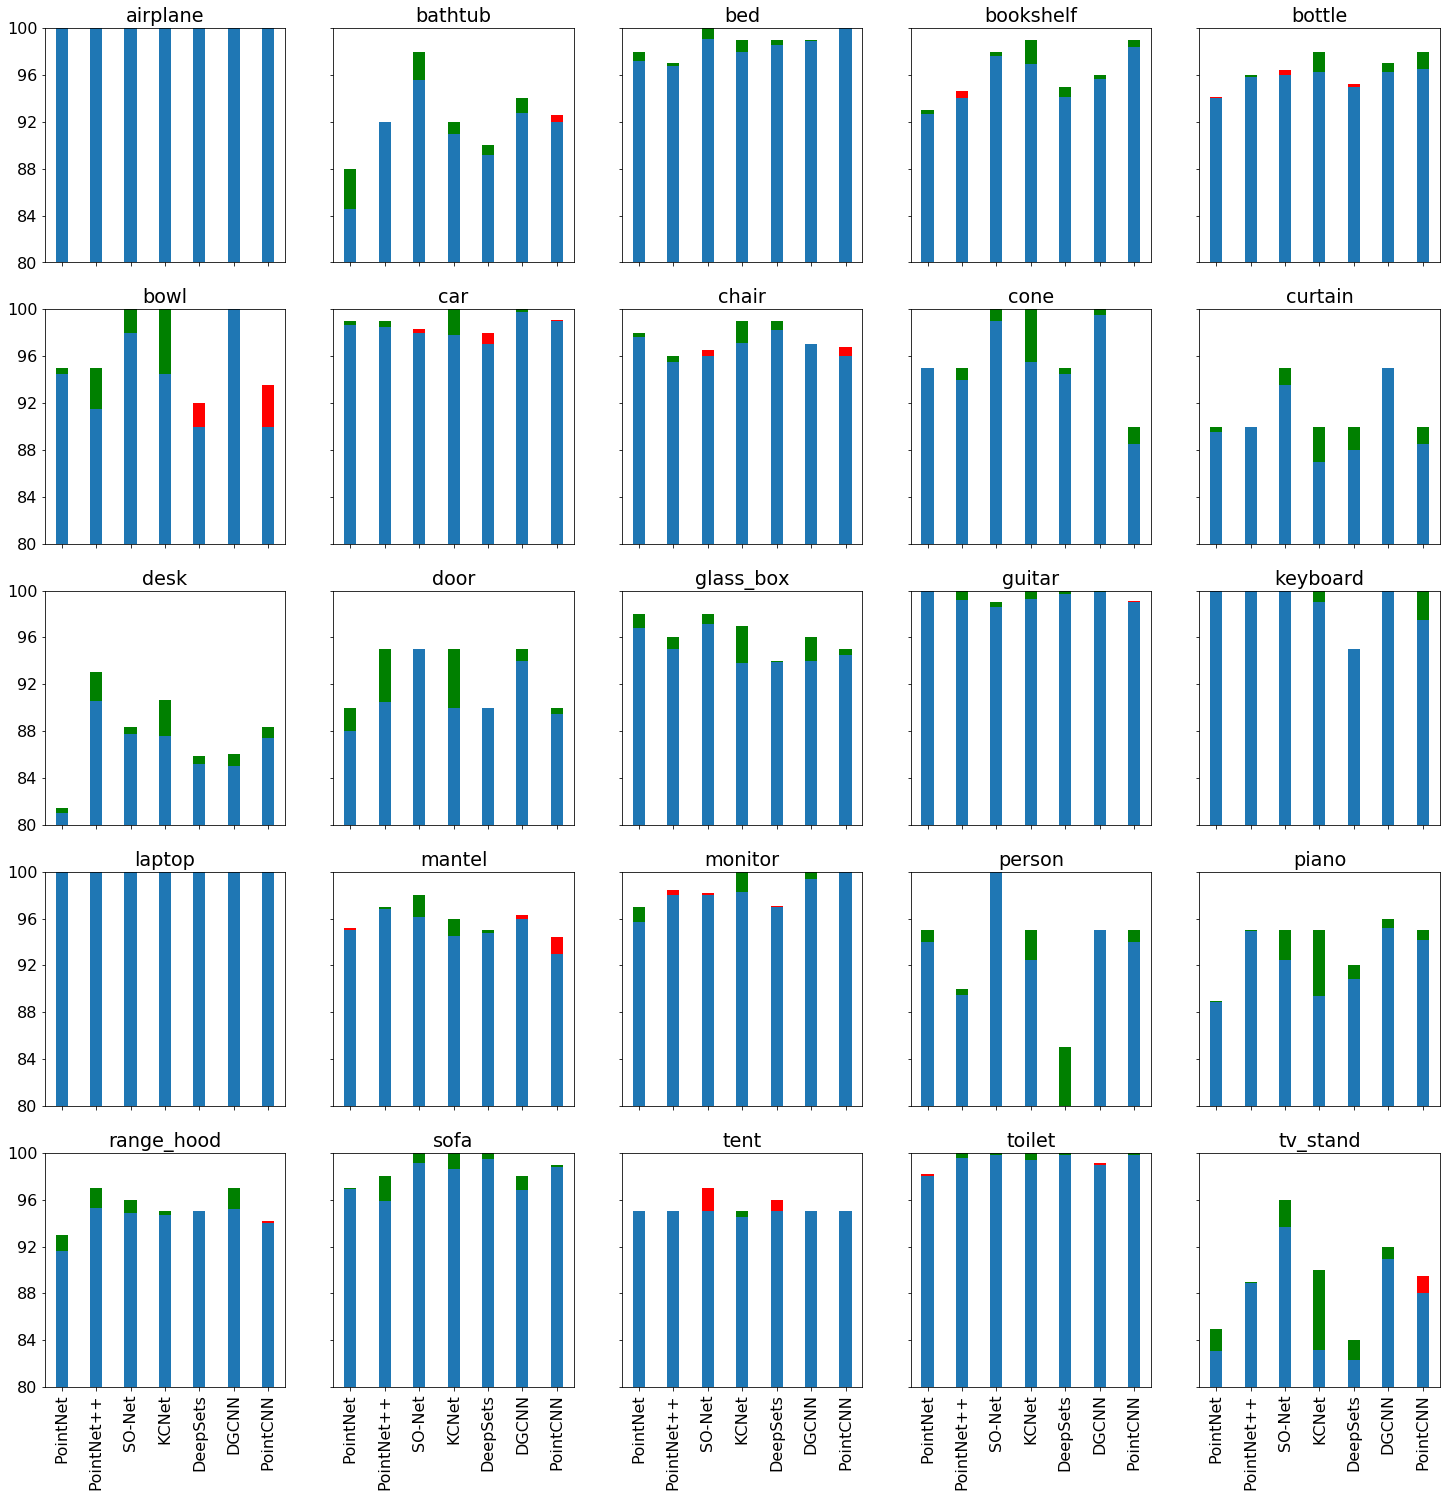

In [26]:
f = draw_class_accs(high_acc_classes, [80, 100])
f.savefig('class_accuracy_2.png', bbox_inches='tight')

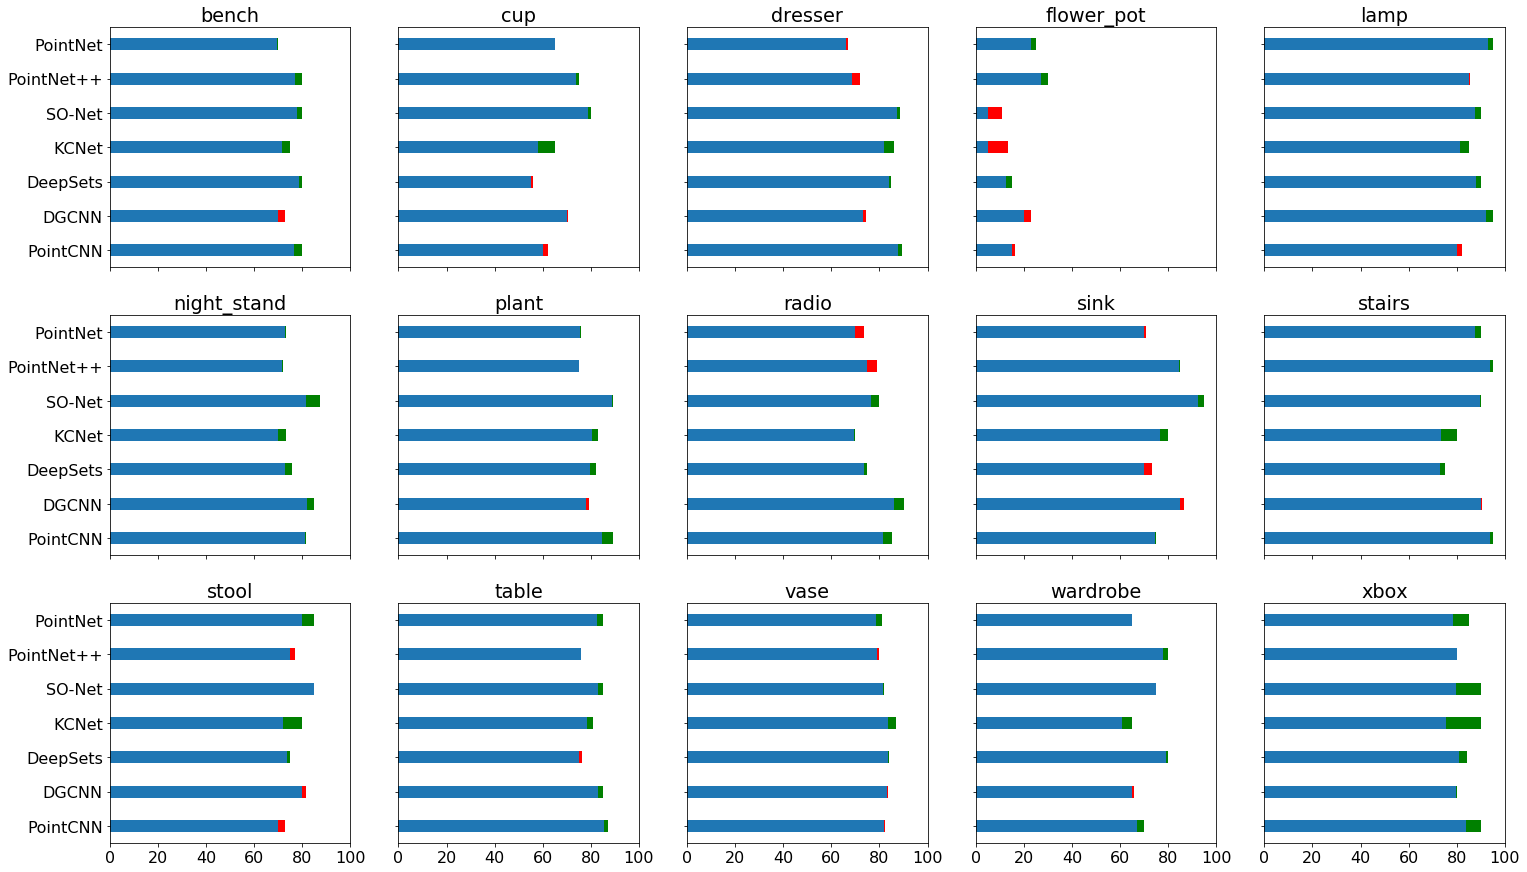

In [30]:
def draw_class_accs_horizontal(acc_classes_list, y_lim):
    ind = np.arange(len(BASE_MODELS))    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    num_cols = 5
    num_rows = int(len(acc_classes_list) / num_cols)
    f, axes = plt.subplots(num_rows, num_cols, sharey=True, sharex=True, figsize=(25, 5 * num_rows))
    plt.setp(axes, yticks=ind, yticklabels=np.flip(BASE_MODELS_ALIASES), xticks=range(y_lim[0],y_lim[1] + 1, int((y_lim[1]-y_lim[0])/5)))

    for c in range(num_cols):
        for r in range(num_rows):
            tmp_idx = c + num_cols * r
            idx = acc_classes_list[tmp_idx][1]
            class_plain_mean = [100 * acc_stats_base_models[x][1]['class_accs'][idx]['mean'] for x in BASE_MODELS]
            class_ensemble_mean = [100 * acc_stats_base_models[x][10]['class_accs'][idx]['mean'] for x in BASE_MODELS]
            diff = [class_ensemble_mean[x] - class_plain_mean[x] for x in range(len(class_plain_mean))]
            diff_up = [x if x > 0 else 0 for x in diff]
            diff_down = [x if x < 0 else 0 for x in diff]
            axes[r][c].barh(ind, np.flip(class_plain_mean), width, label='Plain')
            axes[r][c].barh(ind, np.flip(diff_up), width, left=np.flip(class_plain_mean), label='Diff', color='g')
            axes[r][c].barh(ind, np.flip(diff_down), width, left=np.flip(class_plain_mean), label='Diff', color='r')
            axes[r][c].set_title(CLASS_NAMES[idx])
            axes[r][c].set_xlim(y_lim)
    return f

f = draw_class_accs_horizontal(low_acc_classes, [0, 100])
f.savefig('images/class_accuracy_1.png', bbox_inches='tight')

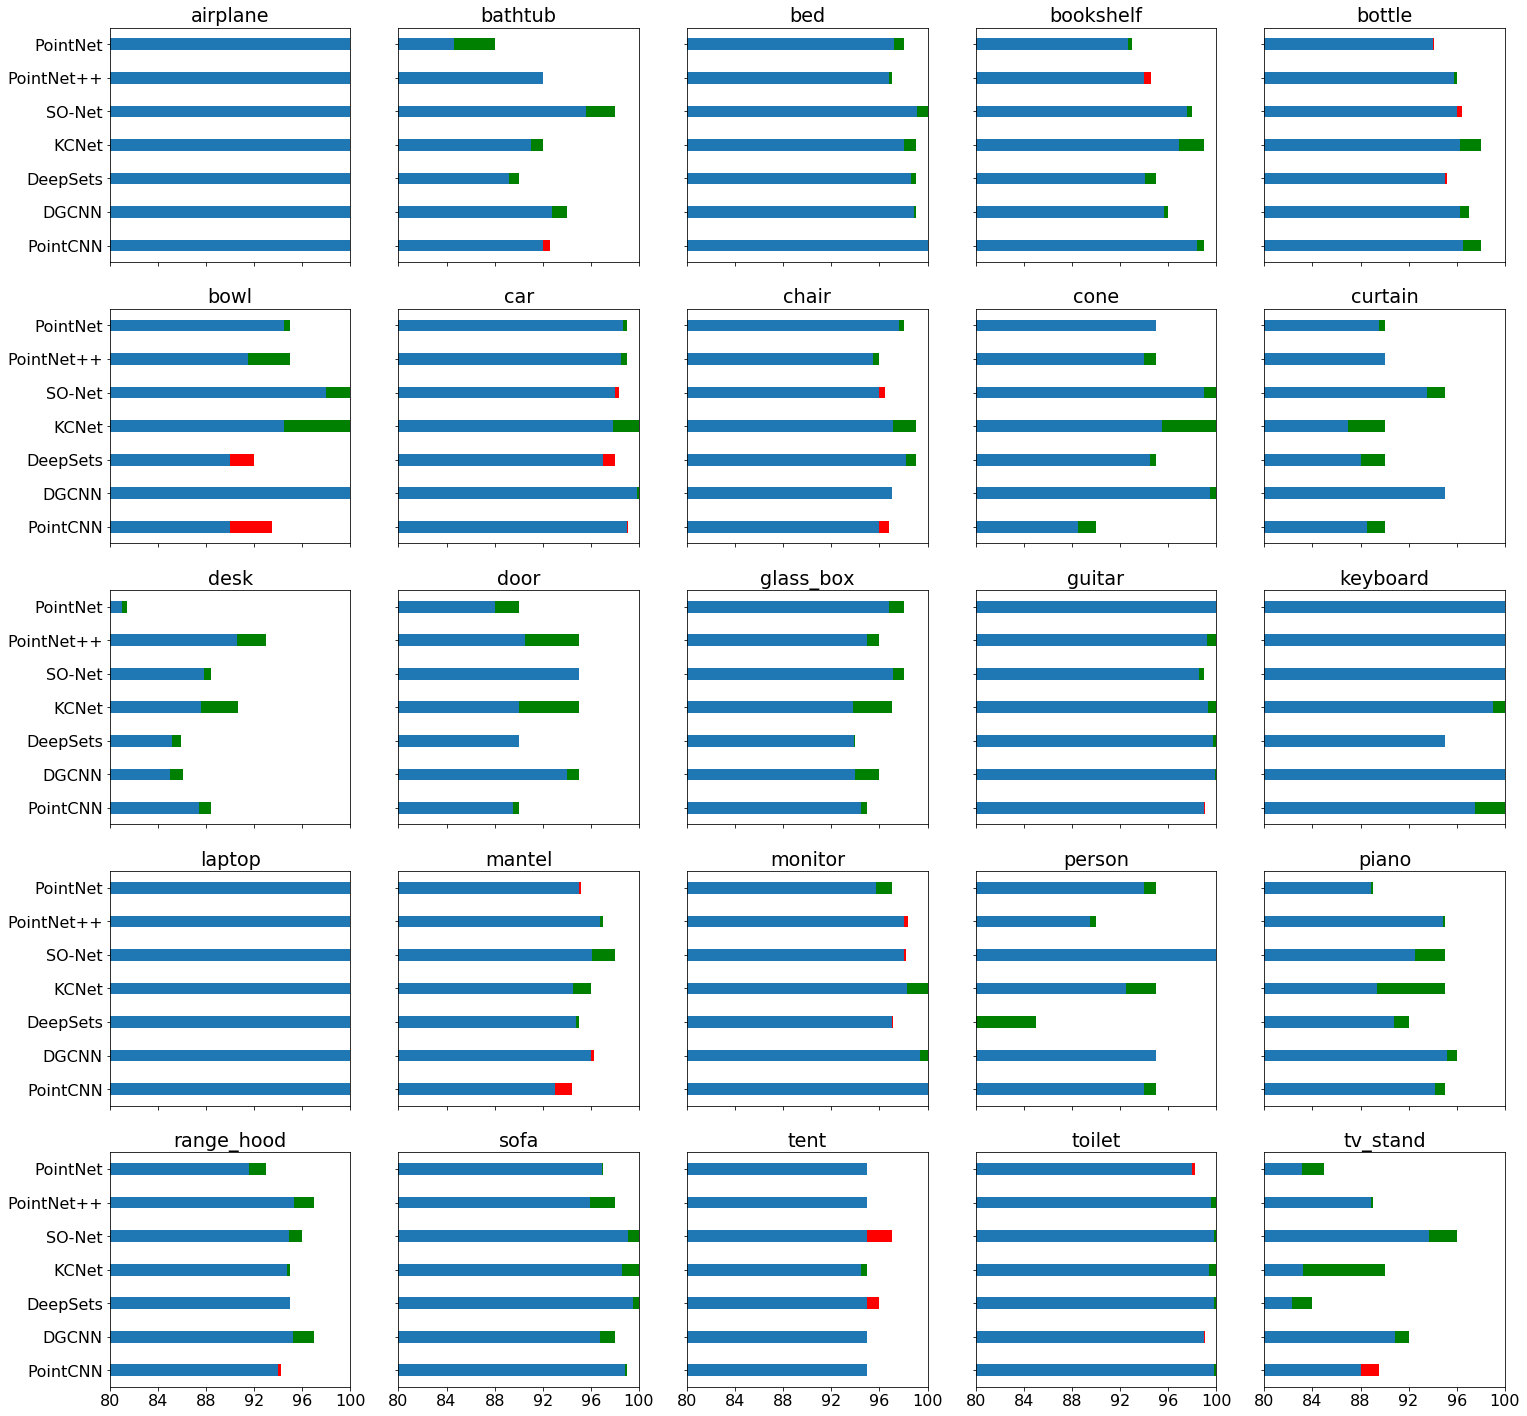

In [31]:
f = draw_class_accs_horizontal(high_acc_classes, [80, 100])
f.savefig('images/class_accuracy_2.png', bbox_inches='tight')

## Models classes best scores
In how many classes is each model the best one?

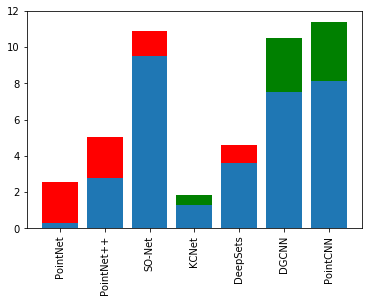

In [35]:
ind = np.arange(len(BASE_MODELS))
models_wins_plain = {x: 0 for x in BASE_MODELS}
models_wins_ensemble = {x: 0 for x in BASE_MODELS}
for idx in range(CLASSES_COUNT):
    class_plain_mean = sorted([(acc_stats_base_models[x][1]['class_accs'][idx]['mean'], x) for x in BASE_MODELS],
                              key=lambda x: x[0])
    class_ensemble_mean = sorted([(acc_stats_base_models[x][10]['class_accs'][idx]['mean'], x) for x in BASE_MODELS],
                                 key=lambda x: x[0])
    num_winners = 0.
    for j in range(len(class_plain_mean)):
        if class_plain_mean[-1][0] == class_plain_mean[j][0]:
            num_winners += 1.
    for j in range(len(class_plain_mean)):
        if class_plain_mean[-1][0] == class_plain_mean[j][0]:
            models_wins_plain[class_plain_mean[j][1]] += 1./num_winners
            models_wins_ensemble[class_ensemble_mean[j][1]] += 1./num_winners

    base = [models_wins_plain[x] for x in BASE_MODELS]

plt.bar(ind, base, tick_label=BASE_MODELS_ALIASES)
diff = [models_wins_ensemble[x] - models_wins_plain[x] for x in BASE_MODELS]
diff_up = [x if x>0 else 0 for x in diff]
diff_down = [x if x<0 else 0 for x in diff]
plt.bar(ind, diff_up, color='g', bottom=base, tick_label=BASE_MODELS_ALIASES)
plt.bar(ind, diff_down, color='r', bottom=base, tick_label=BASE_MODELS_ALIASES)
plt.ylim((0.0, 12.0))
plt.yticks(fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.savefig('images/whos_the_best.png', bbox_inches='tight')

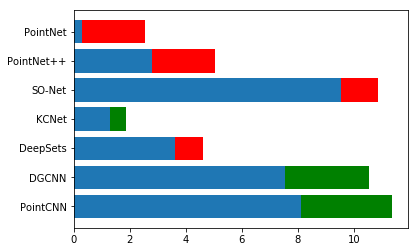

In [37]:
plt.barh(ind, np.flip(base, axis=-1), tick_label=np.flip(BASE_MODELS_ALIASES, axis=-1))
plt.barh(ind, np.flip(diff_up, axis=-1), color='g', left=np.flip(base, axis=-1), tick_label=np.flip(BASE_MODELS_ALIASES, axis=-1))
plt.barh(ind, np.flip(diff_down, axis=-1), color='r', left=np.flip(base, axis=-1), tick_label=np.flip(BASE_MODELS_ALIASES, axis=-1))
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.savefig('images/whos_the_best_horizontal.png', bbox_inches='tight')

In [23]:
ORDERED_MODELS = ['pointnet', 'pointnet++', 'so-net', 'kcnet', 'dgcnn', 'pointcnn']
model_pairs = []
for i in range(len(ORDERED_MODELS)):
    model_i = ORDERED_MODELS[i]
    for j in range(i+1, len(ORDERED_MODELS)):
        model_j = ORDERED_MODELS[j]
        for f in np.arange(0.1, 1.0, 0.1):
            model_name = model_i + '_' + model_j + '_' + '{:2.2}'.format(f)
            probabilities[model_name] = {'activations' :(f * probabilities[model_i]['activations']) +\
                            ((1.0 - f) * probabilities[model_j]['activations'])}
            true_labels[model_name] = true_labels[model_i]
            model_pairs.append(model_name)
acc_stats_models_pairs = get_accuracy_stats(ORDERED_MODELS + model_pairs)

In [24]:
data = []
TOTAL_MODELS_NUMBER = 5
indices = []
for model in ORDERED_MODELS + model_pairs:
    if 'so-net' not in model:
        continue
    indices.append(model)
    data.append([100 * acc_stats_models_pairs[model][1]['acc']['mean'],
                 100 * acc_stats_models_pairs[model][TOTAL_MODELS_NUMBER]['acc']['mean'],
                 100 * acc_stats_models_pairs[model][1]['mean_class_acc']['mean'],
                 100 * acc_stats_models_pairs[model][TOTAL_MODELS_NUMBER]['mean_class_acc']['mean']])
data.append([100 * acc_stats_base_models['so-net'][2]['acc']['mean'],
                 100 * acc_stats_base_models['so-net'][10]['acc']['mean'],
                 100 * acc_stats_base_models['so-net'][2]['mean_class_acc']['mean'],
                 100 * acc_stats_base_models['so-net'][10]['mean_class_acc']['mean']])
pd.options.display.float_format = '{:,.2f}%'.format
df = pd.DataFrame(data, columns=['Plain acc mean', 'Ensemble acc mean', 
                                 'Plain class acc mean', 'Ensemble class acc mean'], index= indices + ['SO-Net x2'])
df['Increase acc'] = df['Ensemble acc mean'] - df['Plain acc mean']
df['Increase class acc'] = df['Ensemble class acc mean'] - df['Plain class acc mean']
display(df.sort_values(by=['Ensemble acc mean', 'Ensemble class acc mean']).tail())
display(df.sort_values(by=['Plain acc mean', 'Ensemble class acc mean']).tail())
display(df.sort_values(by=['Ensemble class acc mean', 'Ensemble class acc mean']).tail())
display(df.sort_values(by=['Plain class acc mean', 'Ensemble class acc mean']).tail())
display(df)

,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
so-net_pointcnn_0.9,93.34%,93.87%,90.75%,91.22%,0.53%,0.46%
so-net_pointcnn_0.6,93.51%,93.89%,90.69%,91.07%,0.38%,0.39%
so-net_dgcnn_0.9,93.64%,93.95%,91.59%,91.99%,0.30%,0.40%
so-net_pointcnn_0.7,93.54%,94.01%,90.90%,91.37%,0.47%,0.47%
so-net_pointcnn_0.8,93.55%,94.03%,90.97%,91.50%,0.48%,0.53%


,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
so-net_dgcnn_0.8,93.42%,93.84%,91.30%,91.84%,0.42%,0.53%
so-net_pointcnn_0.6,93.51%,93.89%,90.69%,91.07%,0.38%,0.39%
so-net_pointcnn_0.7,93.54%,94.01%,90.90%,91.37%,0.47%,0.47%
so-net_pointcnn_0.8,93.55%,94.03%,90.97%,91.50%,0.48%,0.53%
so-net_dgcnn_0.9,93.64%,93.95%,91.59%,91.99%,0.30%,0.40%


,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
pointnet++_so-net_0.5,93.14%,93.45%,91.04%,91.51%,0.30%,0.47%
pointnet++_so-net_0.3,93.41%,93.77%,91.33%,91.65%,0.37%,0.31%
pointnet++_so-net_0.4,93.31%,93.65%,91.26%,91.70%,0.34%,0.44%
so-net_dgcnn_0.8,93.42%,93.84%,91.30%,91.84%,0.42%,0.53%
so-net_dgcnn_0.9,93.64%,93.95%,91.59%,91.99%,0.30%,0.40%


,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
pointnet++_so-net_0.2,93.36%,93.76%,91.12%,91.45%,0.40%,0.33%
pointnet++_so-net_0.4,93.31%,93.65%,91.26%,91.70%,0.34%,0.44%
so-net_dgcnn_0.8,93.42%,93.84%,91.30%,91.84%,0.42%,0.53%
pointnet++_so-net_0.3,93.41%,93.77%,91.33%,91.65%,0.37%,0.31%
so-net_dgcnn_0.9,93.64%,93.95%,91.59%,91.99%,0.30%,0.40%


,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
so-net,92.65%,93.56%,89.98%,90.87%,0.91%,0.89%
pointnet_so-net_0.1,93.09%,93.67%,90.66%,91.01%,0.58%,0.35%
pointnet_so-net_0.2,93.21%,93.68%,90.84%,91.24%,0.47%,0.41%
pointnet_so-net_0.3,93.23%,93.65%,90.95%,91.43%,0.43%,0.48%
pointnet_so-net_0.4,93.10%,93.55%,90.83%,91.43%,0.44%,0.60%
pointnet_so-net_0.5,92.88%,93.24%,90.54%,91.11%,0.37%,0.57%
pointnet_so-net_0.6,92.44%,92.84%,90.02%,90.59%,0.39%,0.57%
pointnet_so-net_0.7,91.72%,92.15%,89.08%,89.67%,0.44%,0.59%
pointnet_so-net_0.8,90.97%,91.51%,88.22%,88.91%,0.53%,0.70%
pointnet_so-net_0.9,90.04%,90.60%,87.15%,87.94%,0.56%,0.79%


In [ ]:
all_models_marged_with_sonet = []
for f_pointnet in np.arange(0.0, 0.4, 0.05):
    for f_pointnetpp in np.arange(0.0, 0.4, 0.05):
        for f_kcnet in np.arange(0.0, 0.4, 0.05):
            for f_dgcnn in np.arange(0.0, 0.4, 0.05):
                for f_pointcnn in np.arange(0.0, 0.4, 0.05):
                    f_sonet = 1.0 - (f_pointnet + f_pointnetpp + f_kcnet + f_dgcnn + f_pointcnn)
                    if f_sonet <= 0.4:
                        continue
                    model_name = \
                        'pointnet_{:2.2}_pointnetpp_{:2.2}_kcnet_{:2.2}_dgcnn_{:2.2}_pointcnn_{:2.2}_sonet_{:2.2}'.format(
                        f_pointnet, f_pointnetpp, f_kcnet, f_dgcnn, f_pointcnn, f_sonet)
                    probabilities[model_name] = {'activations':
                                                (f_pointnet * probabilities['pointnet']['activations']) + \
                                                (f_pointnetpp * probabilities['pointnet++']['activations']) + \
                                                (f_kcnet * probabilities['kcnet']['activations']) + \
                                                (f_dgcnn * probabilities['dgcnn']['activations']) + \
                                                (f_pointcnn * probabilities['pointcnn']['activations']) +\
                                                (f_sonet * probabilities['so-net']['activations'])
                                                }
                    true_labels[model_name] = true_labels['pointnet']
                    all_models_marged_with_sonet.append(model_name)
acc_stats_all_models_marged_with_sonet = get_accuracy_stats(ORDERED_MODELS + all_models_marged_with_sonet)

In [1]:
data = []
TOTAL_MODELS_NUMBER = 5
for model in ORDERED_MODELS + all_models_marged_with_sonet:
    data.append([100 * acc_stats_all_models_marged_with_sonet[model][1]['acc']['mean'],
                 100 * acc_stats_all_models_marged_with_sonet[model][TOTAL_MODELS_NUMBER]['acc']['mean'],
                 100 * acc_stats_all_models_marged_with_sonet[model][1]['mean_class_acc']['mean'],
                 100 * acc_stats_all_models_marged_with_sonet[model][TOTAL_MODELS_NUMBER]['mean_class_acc']['mean']])
pd.options.display.float_format = '{:,.2f}%'.format
df = pd.DataFrame(data, columns=['Plain acc mean', 'Ensemble acc mean', 
                                 'Plain class acc mean', 'Ensemble class acc mean'], 
                  index=ORDERED_MODELS + all_models_marged_with_sonet)
df['Increase acc'] = df['Ensemble acc mean'] - df['Plain acc mean']
df['Increase class acc'] = df['Ensemble class acc mean'] - df['Plain class acc mean']
df.sort_values(by=['Ensemble acc mean', 'Ensemble class acc mean']).tail()

NameError: name 'ORDERED_MODELS' is not defined

In [ ]:
df.sort_values(by=['Ensemble class acc mean', 'Ensemble acc mean']).tail()

## SO-Net random factors analisys

In [ ]:
acc_stats_sonet_const = get_accuracy_stats(SONET_CONST_MODELS, 'activations')

In [ ]:
data = []
for model in SONET_CONST_MODELS:
    data.append([100 * acc_stats_sonet_const[model][1]['acc']['mean'],
                100 * acc_stats_sonet_const[model][5]['acc']['mean'],
                100 * acc_stats_sonet_const[model][1]['mean_class_acc']['mean'],
                100 * acc_stats_sonet_const[model][5]['mean_class_acc']['mean']])
model = 'so-net'
data.append([100 * acc_stats_base_models[model][1]['acc']['mean'],
                100 * acc_stats_base_models[model][5]['acc']['mean'],
                100 * acc_stats_base_models[model][1]['mean_class_acc']['mean'],
                100 * acc_stats_base_models[model][5]['mean_class_acc']['mean']])
pd.options.display.float_format = '{:,.2f}%'.format
df = pd.DataFrame(data, columns=['Plain acc mean', 'Ensemble acc mean', 
                                 'Plain class acc mean', 'Ensemble class acc mean'], 
                  index=SONET_CONST_MODELS + ['so-net'])
df['Increase acc'] = df['Ensemble acc mean'] - df['Plain acc mean']
df['Increase class acc'] = df['Ensemble class acc mean'] - df['Plain class acc mean']
df

In [ ]:
data = []
TOTAL_NUM_MODELS = 5
for model in SONET_CONST_MODELS:
    data.append([100 * acc_stats_sonet_const[model][1]['acc']['mean'],
                 100 * acc_stats_sonet_const[model][TOTAL_NUM_MODELS]['acc']['mean'],
                 100 * acc_stats_sonet_const[model][1]['mean_class_acc']['mean'],
                 100 * acc_stats_sonet_const[model][TOTAL_NUM_MODELS]['mean_class_acc']['mean']])
model = 'so-net'
data.append([100 * acc_stats_base_models[model][1]['acc']['mean'],
                 100 * acc_stats_base_models[model][TOTAL_NUM_MODELS]['acc']['mean'],
                 100 * acc_stats_base_models[model][1]['mean_class_acc']['mean'],
                 100 * acc_stats_base_models[model][TOTAL_NUM_MODELS]['mean_class_acc']['mean']])
pd.options.display.float_format = '{:,.2f}%'.format
df = pd.DataFrame(data, columns=['Plain acc mean', 'Ensemble acc mean', 
                                 'Plain class acc mean', 'Ensemble class acc mean'], 
                  index=SONET_CONST_MODELS + ['so-net_FFF'])
df['Increase acc'] = df['Ensemble acc mean'] - df['Plain acc mean']
df['Increase class acc'] = df['Ensemble class acc mean'] - df['Plain class acc mean']
df.sort_values(by=['Increase acc'])

# Class accuracy in function of samples

In [ ]:
class_counts_train = {}
with open('/home/chechli/ModelNet/modelnet40-normal_numpy/modelnet40_train.txt') as f:
    for row in f:
        tmp = row.split('_')
        if(len(tmp) == 2):
            class_name = tmp[0]
        else:
            class_name = tmp[0] + '_' +tmp[1]
        if class_name not in class_counts_train:
            class_counts_train[class_name] = 0
        class_counts_train[class_name] += 1
print(class_counts_train)

In [ ]:
x = []
y = []
for i in range(len(CLASS_NAMES)):
    class_name = CLASS_NAMES[i]
    class_train_samples = class_counts_train[class_name]
    x.append(class_train_samples)
    class_acc = 100 * acc_stats_base_models['so-net'][1]['class_accs'][i]['mean']
    y.append(class_acc)
    plt.scatter(x, y)